In [1]:
import pygeostat as gs
import gglib as gg
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, copy, shutil, sys, glob, time
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
from collections import OrderedDict
import numba
from gglib.datamgmt.simpleio import *
%matplotlib inline

In [2]:
sys.path.insert(0, 'C:/GIT/python-local/spatialcluster/')
import spatialcluster as sp
mpl.rcParams['figure.figsize'] = (5, 5)

In [3]:
variables = ['Ni', 'Fe', 'SiO2', 'MgO']
nsvariables = [f'NS_{v}' for v in variables]

In [4]:
sys.path.insert(0, '../')
from validator import exporter as exp
exp.init_project('nilat_')
exportfigure = exp.exportfigure

# import data

In [5]:
points = gg.PointContainer("nilat_maincats.dat")
griddef = gs.GridDef(open('griddef', 'r').read())

In [6]:
domains = [i + 1 for i in range(len(np.unique(points["modelcats"])))]

# small dataset description

In [7]:
ndata = len(points)
ndh = len(np.unique(points["Hole ID"]))
nvar = len(nsvariables)
print(f"{ndata} data, from {ndh} drill holes, with {nvar} variables")

5915 data, from 499 drill holes, with 4 variables


In [8]:
project = "nilat"

# Location Maps & Maps of Modeling Categories

In [9]:
commonkwargs = dict(s=11, lw=0.01, grid=True, rotateticks=(0, 90), cbar=False, 
                    cmap="viridis", rasterized=True)

In [10]:
griddef

In [11]:
from matplotlib import gridspec
def gen_nested_locmaps(points, catcol, plot_kws, label="Rock Types", asp1=5, asp2=5, 
                       cmap=None, vlim=None):
    if cmap is not None:
        plot_kws["cmap"] = cmap
    fig = plt.figure(figsize=(12, 6))
    outer = gridspec.GridSpec(1, 2, wspace=0.15, hspace=0.0, width_ratios=[0.80,1])
    leftspec = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
    leftax = plt.Subplot(fig, leftspec[0])

    rightspec = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[1], hspace=0.15)
    rightax1 = plt.Subplot(fig, rightspec[0])
    rightax2 = plt.Subplot(fig, rightspec[1])

    gs.locmap(points, var=catcol, griddef=griddef, **plot_kws, sliceno=15, slicetol=2, 
              ax=leftax, orient="xy", title="Plan View")
    gs.locmap(points, var=catcol, griddef=griddef, **plot_kws, sliceno=50, slicetol=4,
              ax=rightax1, orient="xz", aspect=asp1, title="E-W Section Looking North")
    gs.locmap(points, var=catcol, griddef=griddef, **plot_kws, sliceno=50, slicetol=4,
              ax=rightax2, orient="yz", aspect=asp2, title="N-S Section Looking West")

    for ax in [leftax, rightax1, rightax2]:
        ax.tick_params('y', rotation=90)
        ax.locator_params('y', nbins=3)
        fig.add_subplot(ax)
        
    cbarax = gg.nested_colorbar(points[catcol], ax=rightax2, cmap=plot_kws["cmap"], label=label, 
                                xy=(0.5, 1.1), width=0.8, height=0.03, vlim=vlim)
    cbarax.set_yticks([])
    return fig

In [12]:
def remove_x(axs, xs):
    for x in xs:
        axs[x].set_xlabel("")
        axs[x].xaxis.set_ticklabels([])
def remove_y(axs, ys):
    for y in ys:
        axs[y].set_ylabel("")
        axs[y].yaxis.set_ticklabels([])

In [13]:
cols = ['Ore Type', "modelcats", "mvclus", "agglom", "betteragglom"]
labels = ["Rock Types", "Geological Categories", "Multivariate Clusters", "Spatial Clusters", 
          "Improved Spatial Clusters"]

In [14]:
import warnings; warnings.filterwarnings('ignore')

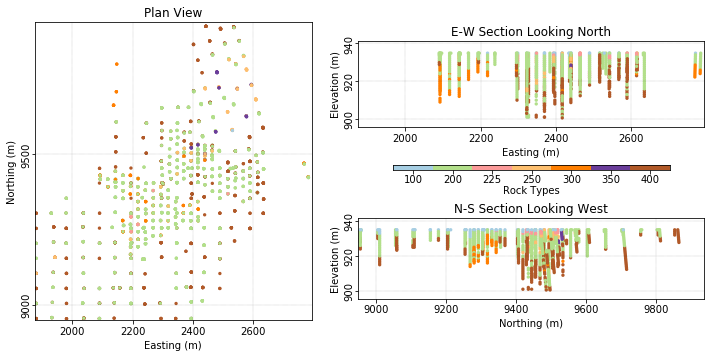

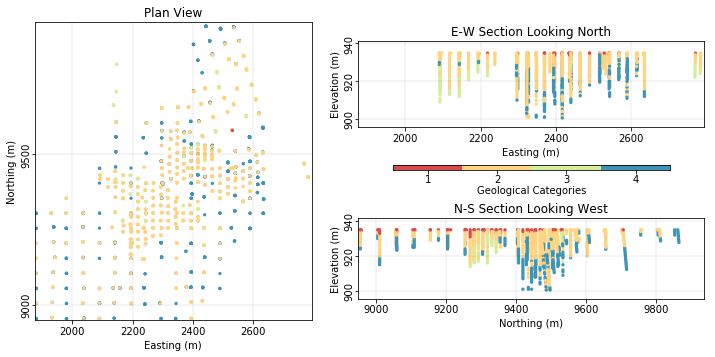

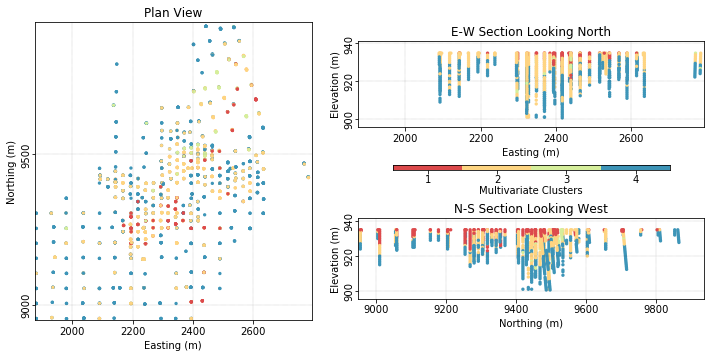

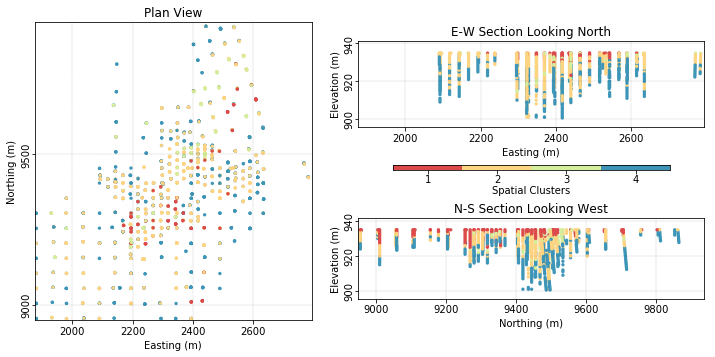

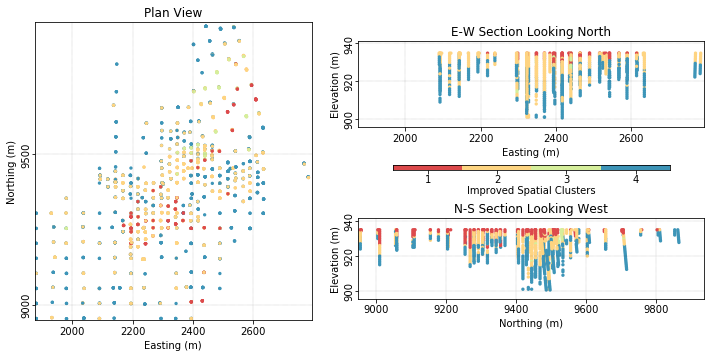

In [15]:
for col, label in zip(cols, labels):
    cmap = 'Spectral' if col != 'Ore Type' else 'Paired'
    fig = gen_nested_locmaps(points, col, commonkwargs, cmap=cmap, label=label, asp1=5, asp2=5)
    if col == "Ore Type":
        col = "OreType"
    plt.tight_layout()
    exportfigure(f'locmapsbycat_{col}.pdf', chap=6)    

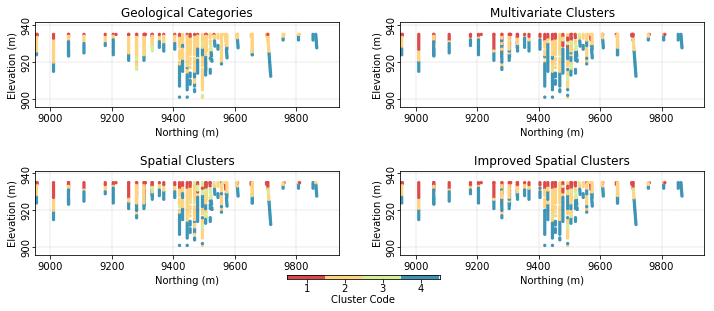

In [16]:
commonkwargs['cmap'] = 'Spectral'
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
for col, label, oax in zip(cols[1:], labels[1:], axes.flatten()):
    gs.locmap(points, var=col, griddef=griddef, **commonkwargs, sliceno=50, slicetol=3,
              ax=oax, orient="yz", aspect=6, title=label)
cbarax = gg.nested_colorbar(points[col], oax, cmap=commonkwargs['cmap'], 
                            xy=(-0.12, -0.25), width=0.5, label='Cluster Code')
cbarax.set_yticks([])
exportfigure('clusterviews_yz.pdf', chap=6)

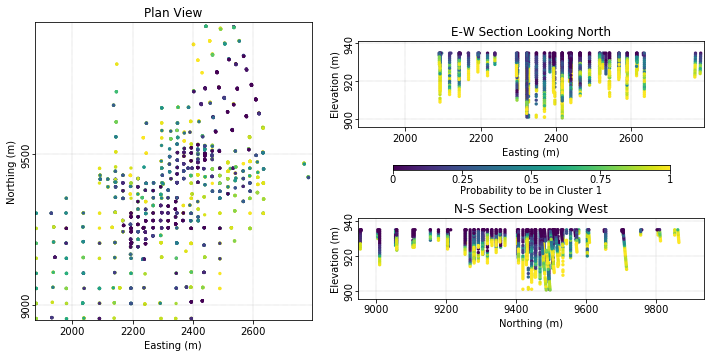

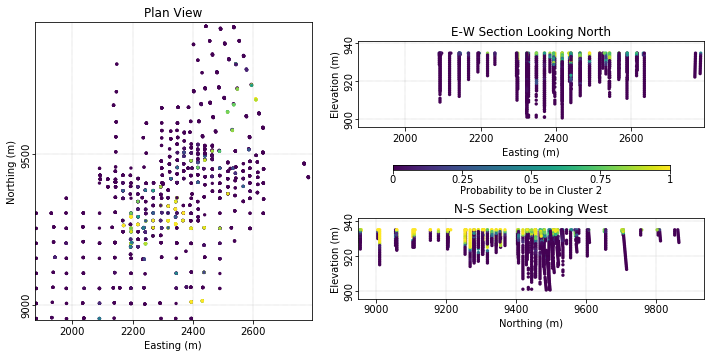

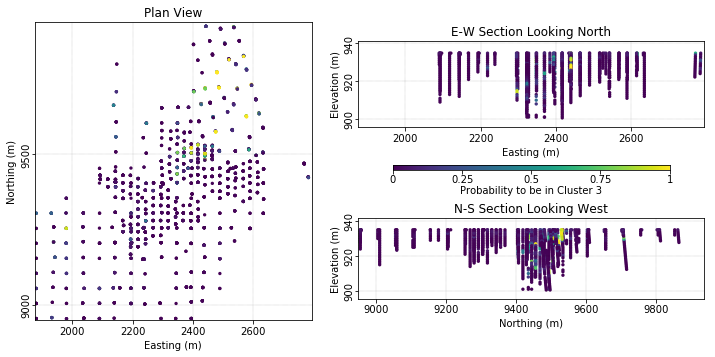

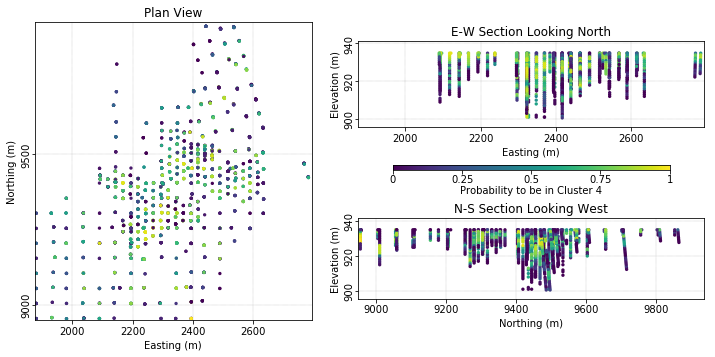

In [17]:
nclus = len(np.unique(points["mvclus"]))
for i in range(1, nclus + 1):
    fig = gen_nested_locmaps(points, f"clus{i}prob", commonkwargs, cmap="viridis", vlim=(0, 1),
                             label=f"Probability to be in Cluster {i}")
    exportfigure(f'probclus{i}.pdf', chap=6)

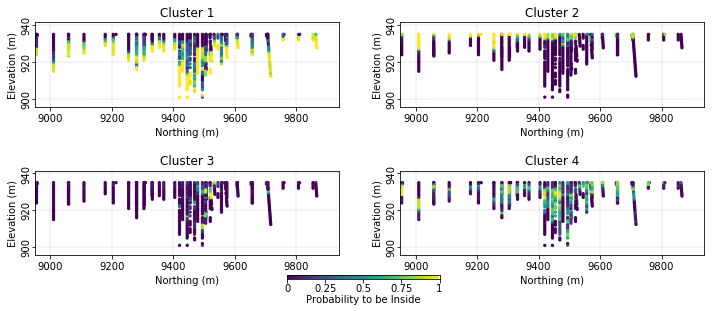

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
commonkwargs['cmap'] = 'viridis'
for iax, ax in enumerate(axes.flatten()):
    i = iax + 1
    gs.locmap(points, var=f"clus{i}prob", griddef=griddef, **commonkwargs, 
              sliceno=50, slicetol=3,
              ax=ax, orient="yz", aspect=6, title=f"Cluster {i}")
cbarax = gg.nested_colorbar(np.arange(0, 1, 0.01), ax, vlim=(0, 1), cmap='viridis', 
                            xy=(-0.12, -0.25), width=0.5, label='Probability to be Inside')
cbarax.set_yticks([])
exportfigure('clusterprobs_yz.pdf', chap=6)

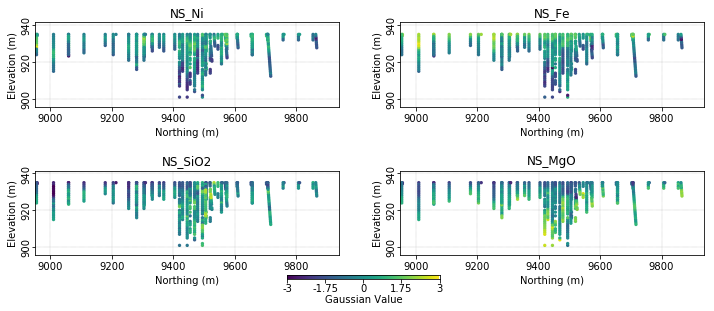

In [19]:
commonkwargs['cmap'] = 'viridis'
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
for iax, ax in enumerate(axes.flatten()):
    var = nsvariables[iax]
    gs.locmap(points, var=var, griddef=griddef, **commonkwargs, sliceno=50, slicetol=3,
              ax=ax, orient="yz", aspect=6, title=var, vlim=(-3, 3))
cbarax = gg.nested_colorbar(points[var], ax, vlim=(-3.5, 3.5), cmap='viridis', 
                            ticklabels=[3, 1.75, 0, -1.75, -3], 
                            xy=(-0.12, -0.25), width=0.5, label='Gaussian Value')
cbarax.set_yticks([])
exportfigure('variablevalues_yz.pdf', chap=6)

# histogram of proportions

In [22]:
props

,Proportion of 1,Proportion of 2,Proportion of 3,Proportion of 4
0,0.158918,0.089603,0.073373,0.678107
1,0.192730,0.224514,0.046492,0.536264
2,0.117836,0.385630,0.095858,0.400676
3,0.133559,0.216737,0.127303,0.522401
4,0.185123,0.356889,0.077430,0.380558
5,0.177008,0.351648,0.078107,0.393238
6,0.202367,0.326965,0.040575,0.430093
7,0.065934,0.222992,0.215046,0.496027
8,0.165680,0.209975,0.093660,0.530685
9,0.133390,0.391209,0.045647,0.429755


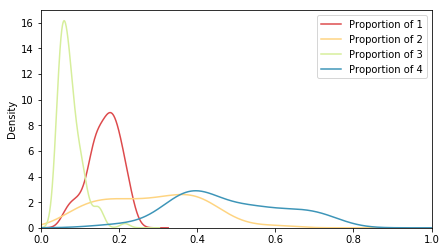

In [39]:
props = []
for ireal in range(100):
    props.append([(points[f'clusreal{ireal}'] == 1).sum() / len(points), 
                  (points[f'clusreal{ireal}'] == 2).sum() / len(points), 
                  (points[f'clusreal{ireal}'] == 3).sum() / len(points), 
                  (points[f'clusreal{ireal}'] == 4).sum() / len(points)])
props = pd.DataFrame(props, columns=['Proportion of 1', 
                                     'Proportion of 2', 
                                     'Proportion of 3', 
                                     'Proportion of 4'])
ax = props.plot.kde(cmap=gg.get_catcmap('Spectral', 4), 
                    figsize=(7, 4))
ax.set_xlim(0, 1)
ax.set_ylim(0, None)

exportfigure('clusreals_props.pdf', chap=6)

In [40]:
prop_short = props.copy()
prop_short.columns = [f'P{i+1}' for i in range(nclus)]

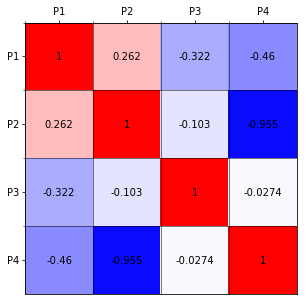

In [41]:
ax = gs.corrmat(prop_short.corr(), figsize=(5, 5))
exp.exportfigure('propcorrmat.pdf')

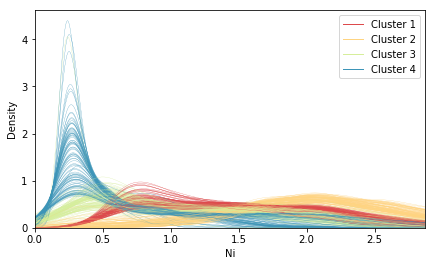

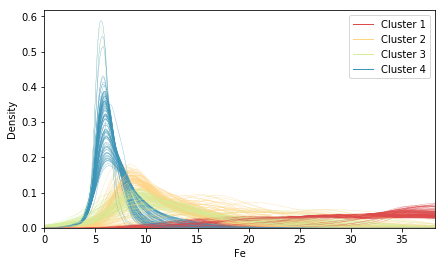

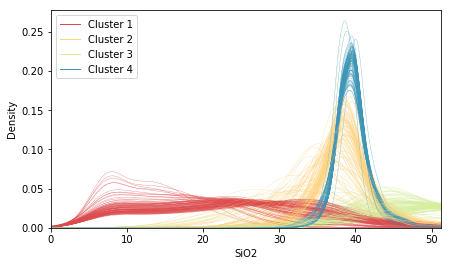

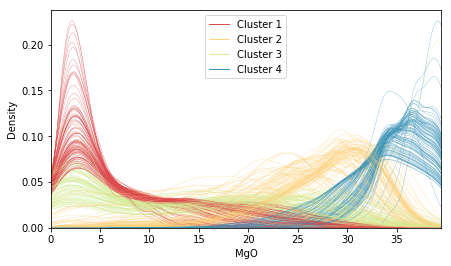

In [42]:
colors = gg.get_catcmap('Spectral', 4).colors
for var in variables:
    f, ax = plt.subplots(figsize=(7, 4))
    cdfx, cdfy = gs.cdf(points[var], bins=100)
    xlims = (0, cdfx[np.searchsorted(cdfy, 0.95)])
    for ireal in range(100):
        for icat, cat in enumerate([1, 2, 3, 4]):
            dfslice = points.data.loc[points[f'clusreal{ireal}'] == cat, var]
            ax = dfslice.plot.kde(ax=ax, color=colors[icat], lw=0.25, label='_nolegend_')

    ax.plot(np.nan, color=colors[0], lw=1, label='Cluster 1')
    ax.plot(np.nan, color=colors[1], lw=1, label='Cluster 2')
    ax.plot(np.nan, color=colors[2], lw=1, label='Cluster 3')
    ax.plot(np.nan, color=colors[3], lw=1, label='Cluster 4')
    ax.legend()
    ax.set_xlim(xlims)
    ax.set_ybound(0, None)
    ax.set_xlabel(var)
    exportfigure(f'clusreals_hists{var}.pdf', chap=6)

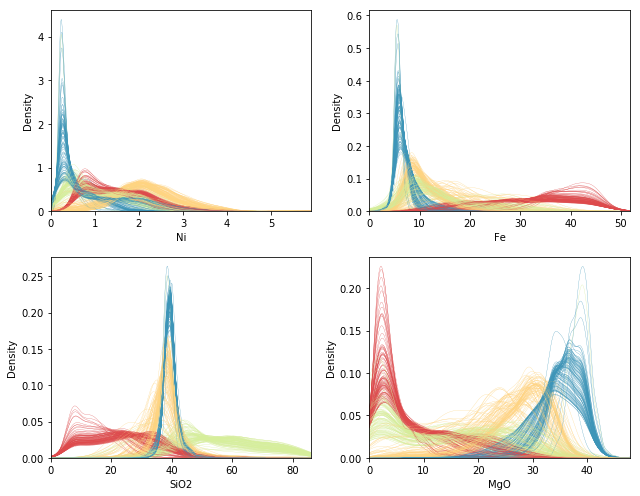

In [44]:
colors = gg.get_catcmap('Spectral', 4).colors
f, axes = plt.subplots(2, 2, figsize=(9, 7))
for var, ax  in zip(variables, axes.flatten()):
    cdfx, cdfy = gs.cdf(points[var], bins=100)
    xlims = (0, points[var].max())
    for ireal in range(100):
        for icat, cat in enumerate([1, 2, 3, 4]):
            dfslice = points.data.loc[points[f'clusreal{ireal}'] == cat, var]
            ax = dfslice.plot.kde(ax=ax, color=colors[icat], lw=0.25, label='_nolegend_')
    for iclus in range(nclus):
        ax.plot(np.nan, color=colors[iclus], lw=1, label=f'Cluster {iclus + 1}')
    ax.set_xlim(xlims)
    ax.set_ybound(0, None)
    ax.set_xlabel(var)
    if var == 'Ni':
        ax.legend()
plt.tight_layout()
exportfigure(f'clusreals_hists_allvars.pdf')

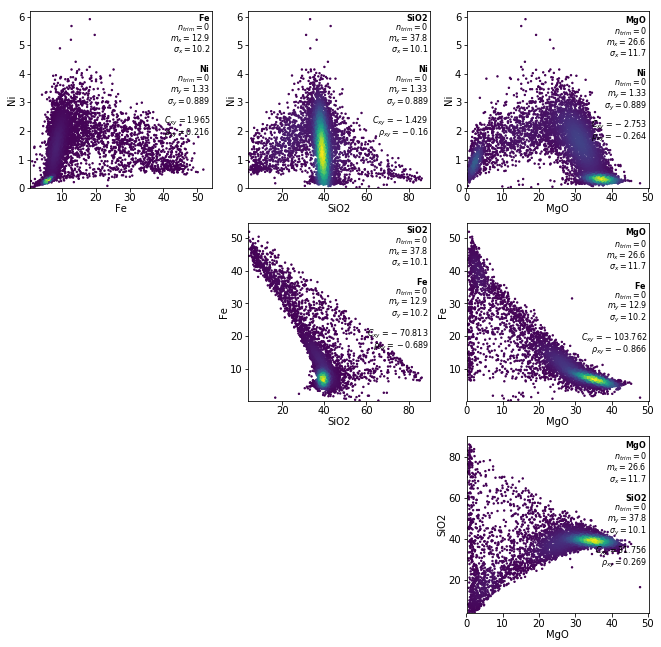

In [51]:
axes = gg.scatplts(points[variables], histdiag=False,
                   scatkws=dict(stat_blk='bivar'))
exp.exportfigure('bivariate_scatter.pdf')